In [156]:
import keras
import numpy as np
from sklearn import preprocessing
from keras.layers import Dense, Input, Embedding, Lambda, Layer, Multiply, Dropout, Dot, Bidirectional, LSTM
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import pandas as pd
from scipy.stats import norm
from math import sqrt 

In [157]:
import codecs, json
import pandas as pd

with codecs.open('./data/pwned.json', 'r', 'utf-8') as f:
    tweets = json.load(f, encoding='utf-8')

list_tweets = [list(elem.values()) for elem in tweets]
list_columns = list(tweets[0].keys())
df = pd.DataFrame(list_tweets, columns=list_columns)

In [158]:
df



,fullname,html,id,likes,replies,retweets,text,timestamp,url,user
0,K.C. Budd ☎️ 🐒,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111773865829490688,1,0,0,"Watch this video, or keep getting pwned on soc...",2019-03-29T23:35:20,/phreakmonkey/status/1111773865829490688,phreakmonkey
1,MR NATIONALIST,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111773052662996992,2,0,0,"Indeed, the left got pwned BIGLY! pic.twitter....",2019-03-29T23:32:06,/iShrike/status/1111773052662996992,iShrike
2,pwned4ever 🍻,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111772925634318336,2,0,0,thank you kindly,2019-03-29T23:31:35,/pwned4ever/status/1111772925634318336,pwned4ever
3,Progressive Voters Vaughan,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111771138382839810,1,0,0,"It might as well just say ""pwned by Doug"" on it",2019-03-29T23:24:29,/VaughanVoters/status/1111771138382839810,VaughanVoters
4,ILM23,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111769751297118210,1,0,0,It will be ready when it’s done it’s been said...,2019-03-29T23:18:59,/pwned24k/status/1111769751297118210,pwned24k
5,Reddit Dota 2,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111768395903627264,17,0,0,"The ""Player"" just pwned ""Enemy"" isnt fully gon...",2019-03-29T23:13:35,/redditdota2/status/1111768395903627264,redditdota2
6,PostPwnedU,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111758917338648576,0,0,0,"Thanks for staying in contact, but Candyman is...",2019-03-29T22:35:56,/PostPwnedU/status/1111758917338648576,PostPwnedU
7,ILM23,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111758228076011520,2,2,0,Fuck off,2019-03-29T22:33:11,/pwned24k/status/1111758228076011520,pwned24k
8,🏴‍☠️ 乃0ｷん™ 🏴‍☠️,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111757919190691856,0,0,0,#Uploadfilter sind schon so 'ne Sache. Pwned!,2019-03-29T22:31:58,/_s0vereign/status/1111757919190691856,_s0vereign
9,ILM23,"<p class=""TweetTextSize js-tweet-text tweet-te...",1111756235932659714,233,19,16,I wouldn’t touch Electra even if it did come o...,2019-03-29T22:25:16,/pwned24k/status/1111756235932659714,pwned24k


word_doc=', '.join(df.text)

searchfor = ['pwned', 'Pwned', 'PWNED']

In [159]:
df['label']=np.where(df['text'].str.contains('pwned|Pwned|PWNED'), '1','0')


In [160]:
new_df=df[['label','text']]

In [161]:
new_df.text

0       Watch this video, or keep getting pwned on soc...
1       Indeed, the left got pwned BIGLY! pic.twitter....
2                                        thank you kindly
3         It might as well just say "pwned by Doug" on it
4       It will be ready when it’s done it’s been said...
5       The "Player" just pwned "Enemy" isnt fully gon...
6       Thanks for staying in contact, but Candyman is...
7                                                Fuck off
8           #Uploadfilter sind schon so 'ne Sache. Pwned!
9       I wouldn’t touch Electra even if it did come o...
10                                                   Nope
11      I call @JoshFrydenberg ‘pwned’, hey, @Bowenchr...
12      The "Player" just pwned "Enemy" isnt fully gon...
13      DAYYYYYYUMMM @honeylemondrops JUST PWNED YOUUUUU 
14        Got me there...this lib is definitely pwned lol
15      That’s me pwned. Enjoy the German countryside....
16      Then update be my guest if you can’t wait and ...
17      Hey u 

In [162]:
with open("pwned.tsv", "w") as f:
    f.write(word_doc)

In [163]:
new_df.to_csv("pwned.tsv", sep='\t',index=False,line_terminator='\n')

In [164]:
def load_embeddings(filename, max_vocab_size):

    vocab={}
    embeddings=[]
    with open(filename) as file:
        
        cols=file.readline().split(" ")
        num_words=int(cols[0])
        size=int(cols[1])
        embeddings.append(np.zeros(size))  # 0 = 0 padding if needed
        embeddings.append(np.zeros(size))  # 1 = UNK
        vocab["_0_"]=0
        vocab["_UNK_"]=1
        
        for idx,line in enumerate(file):

            if idx+2 >= max_vocab_size:
                break

            cols=line.rstrip().split(" ")
            val=np.array(cols[1:])
            word=cols[0]
            
            embeddings.append(val)
            vocab[word]=idx+2

    return np.array(embeddings), vocab, size

In [165]:
def read_data(filename, vocab):
    X=[]
    Y=[]
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            label=cols[0]
            # assumes text is already tokenized
            text=cols[1].split(" ")
            X.append(text)
            Y.append(label)
    return X, Y

In [166]:
def get_word_ids(docs, vocab, max_length=200):
    
    doc_ids=[]
    
    for doc in docs:
        wids=[]
        for token in doc[:max_length]:
            val = vocab[token.lower()] if token.lower() in vocab else 1
            wids.append(val)
        
        # pad each document to constant width
        for i in range(len(wids),max_length):
            wids.append(0)

        doc_ids.append(wids)

    return np.array(doc_ids)

In [167]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file="~/Documents/Applied_NLP/data/glove.42B.300d.50K.txt"
glove_in_w2v_format="~/Documents/Applied_NLP/data/glove.42B.300d.50K.w2v.txt"
_ = glove2word2vec(glove_file, glove_in_w2v_format)

In [168]:
embeddings, vocab, embedding_size=load_embeddings("./data/glove.42B.300d.50K.w2v.txt", 50000)

In [169]:
trainX = get_word_ids(new_df['text'], vocab, max_length=200)

In [194]:
new_df['text'][1]

'Indeed, the left got pwned BIGLY! pic.twitter.com/8qYmgXLl75'

In [188]:
vocab['watch']

458

In [195]:
trainX[1]

array([  14,  857,  796,  877,  877,  796,    2,    1,  770, 1549,  877,
          1, 1264,  877, 1461,  770,    1, 1529, 1325,  770,    1, 1575,
        917,  857,  877,  796,    1,  664,   14, 1529, 1264, 1889,   38,
          1, 1575,   14,  591,    4,  770,  917,   14,  770,  770,  877,
       1245,    4,  591, 1325,  755,   78,  263, 2552, 1889,  755, 1529,
        298, 1264, 1264,  243,  159,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [108]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainX, new_df['label'], test_size=0.2, random_state=42)

In [112]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
Y_train=np.array(le.transform(y_train))
Y_test=np.array(le.transform(y_test))

In [113]:
class AttentionLayerMasking(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(AttentionLayerMasking, self).__init__(**kwargs)


    def build(self, input_shape):
        input_embedding_dim=input_shape[-1]
        
        self.kernel = self.add_weight(name='kernel', 
                            shape=(input_embedding_dim,1),
                            initializer='uniform',
                            trainable=True)
        super(AttentionLayerMasking, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        
        # dot product 
        x=K.dot(x, self.kernel)
        # exponentiate
        x=K.exp(x)
        
        # zero out elements that are masked
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask, axis=-1)
            x = x * mask
        
        # normalize by sum
        x /= K.sum(x, axis=1, keepdims=True)
        x=K.squeeze(x, axis=2)

        return x

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [114]:
def get_bilstm_with_attention_masking(embeddings, lstm_size=25, dropout_rate=0.25):

    vocab_size, word_embedding_dim=embeddings.shape
    
    word_sequence_input = Input(shape=(None,), dtype='int32')
    
    word_embedding_layer = Embedding(vocab_size,
                                    word_embedding_dim,
                                    weights=[embeddings], 
                                    mask_zero=True,
                                    trainable=False)

    
    embedded_sequences = word_embedding_layer(word_sequence_input)
    bilstm_output = Bidirectional(LSTM(lstm_size, return_sequences=True, activation='tanh', dropout=dropout_rate), merge_mode='concat')(embedded_sequences)

    # first let's transform each word embedding into a new vector to use for measuring its importance
    attention_key_dim=300
    attention_input=Dense(attention_key_dim, activation='tanh')(bilstm_output)

    # next we'll pass those transformed inputs through an attention layer, getting back a normalized
    # attention value a_i for each token i; \forall i, 0 <= a_i <= 1; for a document with N words, 
    # \sum_{i=0}^N a_i = 1
    
    attention_output = AttentionLayerMasking(word_embedding_dim, name="attention")(attention_input)
    
    # now let's multiply those attention weights by original inputs to get a weighted average over them
    document_representation = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=1), name='dot')([attention_output,bilstm_output])

    x=Dense(1, activation="sigmoid")(document_representation)

    model = Model(inputs=word_sequence_input, outputs=x)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [115]:
bilstm_attention_model=get_bilstm_with_attention_masking(embeddings, lstm_size=25, dropout_rate=0.25)
print (bilstm_attention_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    15000000    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 50)     65200       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)      

In [116]:
model=bilstm_attention_model

modelName="bilstm_attention_model.hdf5"
checkpoint = ModelCheckpoint(modelName, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

model.fit(X_train, y_train, 
            validation_data=(X_test, y_test),
            epochs=30, batch_size=128,
            callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 1196 samples, validate on 300 samples
Epoch 1/30
1196/1196 [==============================] - 9s 7ms/step - loss: 0.6002 - acc: 0.6848 - val_loss: 0.6366 - val_acc: 0.7200
Epoch 2/30
1196/1196 [==============================] - 6s 5ms/step - loss: 0.5551 - acc: 0.7584 - val_loss: 0.5800 - val_acc: 0.7200
Epoch 3/30
1196/1196 [==============================] - 6s 5ms/step - loss: 0.5367 - acc: 0.7584 - val_loss: 0.5660 - val_acc: 0.7200
Epoch 4/30
1196/1196 [==============================] - 6s 5ms/step - loss: 0.5284 - acc: 0.7584 - val_loss: 0.5650 - val_acc: 0.7200
Epoch 5/30
1196/1196 [==============================] - 6s 5ms/step - loss: 0.5126 - acc: 0.7584 - val_loss: 0.5295 - val_acc: 0.7200
Epoch 6/30
1196/1196 [==============================] - 6s 5ms/step - loss: 0.4697 - acc: 0.7584 - val_loss: 0.4278 - val_acc: 0.7467
Epoch 7/30
1196/1196 [==============================] - 6s 5ms/step - loss: 0.3347 - acc: 0.8395 - va

In [145]:
def analyze(model, doc):
    
    words=doc.split(" ")
    text = get_word_ids([words], vocab, max_length=len(words))
   
    inp = model.input                                    
    outputs = [layer.output for layer in model.layers[1:]]       
    functor = K.function([inp, K.learning_phase()], outputs) 

    test = text[0]
    orig=words
    attention_weights=[]
    test=test.reshape((1,len(words)))
    layer_outs = functor([test, 0.])

    # in this model, attention is the third layer
    attention_layer=layer_outs[3]
    
    for i in range(len(words)):
        val=attention_layer[0,i]
        attention_weights.append(val)
        print ("%.3f\t%s" % (val, orig[i]))
        
    df = pd.DataFrame({'words':orig, 'attention':attention_weights})
    print(df)
    ax = df.plot.bar(x='words', y='attention', figsize=(10,4))

In [146]:
model=bilstm_attention_model
model.load_weights("bilstm_attention_model.hdf5")

0.036	Pwned
0.103	by
0.262	a
0.395	fake
0.071	cow.
0.108	Big
0.007	day
0.009	for
0.005	you,
0.006	huh?
   words  attention
0  Pwned   0.035905
1     by   0.102600
2      a   0.261703
3   fake   0.394774
4   cow.   0.071078
5    Big   0.107857
6    day   0.007183
7    for   0.008789
8   you,   0.004525
9   huh?   0.005587


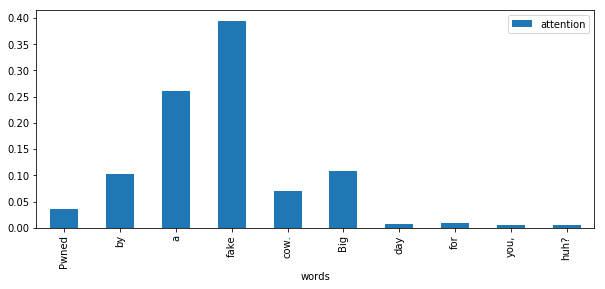

In [151]:
text="Pwned by a fake cow. Big day for you, huh?"
analyze(model, text)

0.761	Got
0.212	me
0.006	there...this
0.001	lib
0.004	is
0.006	definitely
0.001	pwned
0.011	lol
          words  attention
0           Got   0.760589
1            me   0.211675
2  there...this   0.006262
3           lib   0.000594
4            is   0.003751
5    definitely   0.005567
6         pwned   0.000957
7           lol   0.010604


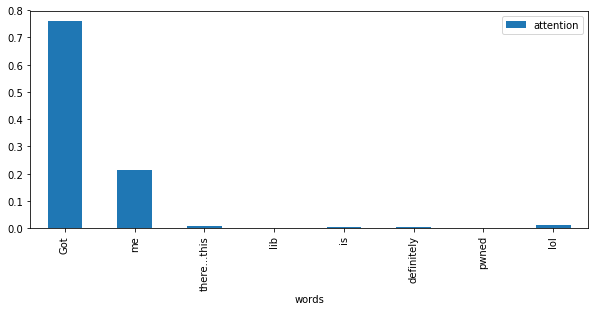

In [154]:
text="Got me there...this lib is definitely pwned lol"
analyze(model, text)